In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('notebook', font_scale=1.3)
sns.set_palette('tab10')
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from toolz import concat
df = pd.read_csv('../krajbich_PNAS_2011/data.csv')
df['fixation'] = list(concat(df.groupby(['subject', 'trial']).apply(lambda x: range(len(x)))))
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index(['subject', 'trial'], inplace=True)
df.rename(columns={
    'roirating': 'roi_rating',
    'leftroi': 'roi1',
    'middleroi': 'roi2',
    'rightroi': 'roi3'
}, inplace=True)
subjects = df.reset_index().subject.unique()

In [4]:
trial_ratings = df.groupby(['subject', 'trial'])[[f'rating{i}' for i in range(1,4)]].mean()
rating_agg = (pd.melt(trial_ratings.reset_index(), id_vars=['subject', 'trial']) 
              .groupby(['subject']).value.agg(['mean', 'std']))

value = trial_ratings.copy()
for s in subjects:
    value.loc[s] = ((value.loc[s] - rating_agg['mean'].loc[s]) / rating_agg['std'].loc[s]).values

In [5]:
import h5py
hf = h5py.File('../data.h5', 'w')
hf.create_dataset('values', data=value.values)
hf.close()

/usr/local/lib/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
roi = df[['roi1', 'roi2', 'roi3']].as_matrix()
df['roi'] = (roi * [1,2,3]).sum(1)
choice = df[['choice1', 'choice2', 'choice3']].as_matrix()
df['choice'] = (choice * [1,2,3]).sum(1)
rank = df[['rating1', 'rating2', 'rating3']].rank(1, ascending=False).astype(int).as_matrix()
roi_rank = (roi * rank).sum(1)
df['roi_rank'] = roi_rank

/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [18]:
def pull_values(row, key):
    x = row[[f'{key}{i}' for i in (1,2,3)]].copy()
    x.index = [1,2,3]
    return x

def others(i):
    return {1,2,3} - {i}

trial = df.loc[1, 1]
def parse_trial(trial):
    last = trial.iloc[-1].astype(int)
    rating = pull_values(last, 'rating')
    fixtime = trial.groupby('roi').eventduration.sum()
    t = {
        'rt': last.rt,
        'subject': last.subject,
        'trial': last.trial,
        'last_fix': last.roi,
        'choice': last.choice,
        'last_duration': last.eventduration,
        'choose_last': last.choice == last.roi,
        'last_fix_value_advantage': rating[last.roi] - rating[others(last.roi)].mean(),
        'last_value': last[f'rating{last.roi}']
    }
    for i in range(1,4):
        t[f'rating{i}'] = last[f'rating{i}']
        t[f'fixtime{i}'] = fixtime.get(i, 0)
    return t

# parse_trial(trial.reset_index())
%time tdf = pd.DataFrame(list(df.reset_index().groupby(['subject', 'trial']).apply(parse_trial))).set_index(['subject', 'trial'])

CPU times: user 9.96 s, sys: 186 ms, total: 10.1 s
Wall time: 10.3 s


In [62]:
tdf['fix_adv1'] = tdf.fixtime1 - (tdf.fixtime2 + tdf.fixtime3) / 2

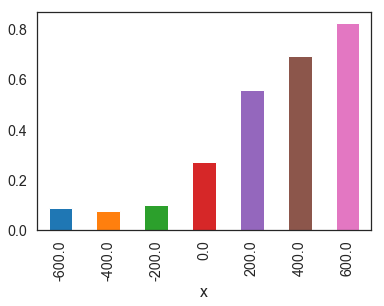

In [63]:
x = tdf['fix_adv1'].values
y = (tdf['choice'] == 1).values
bins = pd.cut(x, np.arange(-700, 701, 200)).map(lambda x: x.mid)
pd.DataFrame({'x': bins, 'y':y}).groupby('x').y.mean().plot.bar()

In [65]:
tdf['n_fix'] = df.groupby(['subject', 'trial']).apply(len)
tdf['value_std'] = value.values.std(1)
tdf['value_max'] = value.values.max(1)
tdf['value_mean'] = value.values.mean(1)
tdf['choice_value'] = value.values[np.arange(len(value)), tdf.choice.values - 1]
tdf.reset_index().to_pickle('data/human_trials')

## Attention → Choice

## Choice quality

In [41]:
choice = np.array(tdf.choice - 1)
tdf['choice_value'] = ratings_z.values[np.arange(len(ratings_z)), choice]
tdf.choice_value.agg(['mean', 'std'])

NameError: name 'ratings_z' is not defined

# Attention over time

/usr/local/lib/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


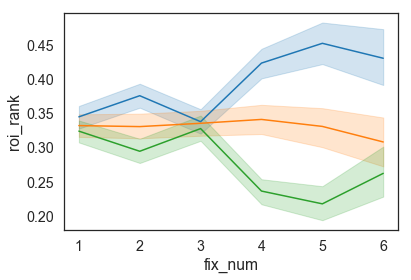

In [25]:
# sns.lineplot('fix_num', 'roi_rank', data=df.query('fix_num <= 6'))
d = df.query('fix_num <= 6')
for i in (1,2,3):
    sns.lineplot(d.fix_num, d.roi_rank == i)

In [44]:
def long_form(df, quant=50):
    for (sub, t), trial in df.reset_index().groupby(['subject', 'trial']):
        step = 0
        for _, fix in (trial.iterrows()):
            for _ in range(int(round(fix.eventduration / quant))):
                x = fix[['subject', 'trial', 'roi', 'roi_rating_z', 'roi_rank']]
                x['step'] = step
                step += quant
                yield x

max_rt = tdf.rt.quantile(0.99)
ldf = pd.DataFrame(long_form(df.reset_index().query('rt < @max_rt')))

/usr/local/lib/miniconda3/lib/python3.6/site-packages/pandas/core/series.py:851: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [ ]:
ldf[['step', 'roi_rank']].rename(columns={'step': 'time', 'roi_rank': 'focus_rank'}).to_pickle('data/human_focus')

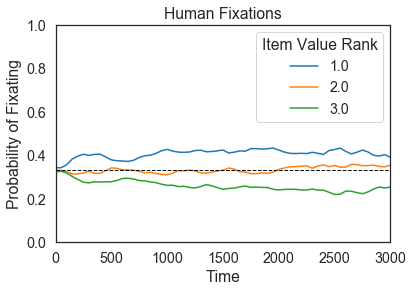

In [99]:
def plot_fixations(ldf):
    n_step = ldf.groupby(['roi_rank', 'step']).apply(len)
    p_step = n_step / n_step.sum(level=1)
    p_step.unstack().T.plot()
    plt.xlim(1,3000)
    plt.ylim(0, 1)
    plt.ylabel('Probability of Fixating')
    plt.xlabel('Time')
    plt.legend(title='Item Value Rank')
    plt.axhline(1/3, c='k', lw=1, ls='--')
    plt.title('Human Fixations');
#     plt.savefig('figs/human_fix.pdf')

plot_fixations(ldf)

[]

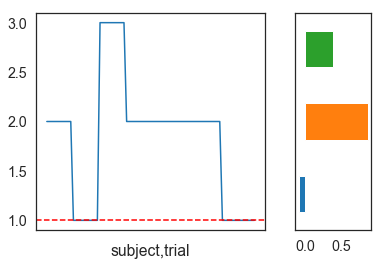

In [275]:
# s, t = np.random.choice(tdf.index)
fig, axes = plt.subplots(1,2, gridspec_kw = {'width_ratios':[3, 1]})
ldf.set_index(['subject', 'trial']).loc[s, t].roi.plot(ax=axes[0])
axes[0].axhline(tdf.loc[s, t].choice, c='r', ls='--')

ratings_z.loc[s, t].plot.barh(ax=axes[1])
axes[1].set_yticks(())
